In [6]:
# first use the standard method to compute the statistics
# by using the data already computed in KUIAS for two hours

import sys
sys.path+=['/Users/lunzhang/anaconda3/lib/python3.6/site-packages']
import DSGRN
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Counting method

In [44]:
def NetworkSpecStr(net_spec):
    net_spec_str = ""

    spec = "SOX17 : "
    activators = ' + '.join([ 'Y' + str(j) for j in range(0,2) if net_spec[j] == 1])
    repressors = ')('.join([ '~Y' + str(j) for j in range(0,2) if net_spec[j] == -1])
    if activators:
        activators = '(' + activators + ')'
    if repressors:
        repressors = '(' + repressors + ')'
    spec += activators + repressors + "\n "
    spec = spec.replace("Y0", "TAFP2C")
    spec = spec.replace("Y1", "ID1")
    net_spec_str += spec

    spec = "TAFP2C : "
    activators = ' + '.join([ 'Y' + str(j) for j in range(2,5) if net_spec[j] == 1])
    repressors = ')('.join([ '~Y' + str(j) for j in range(2,5) if net_spec[j] == -1])
    if activators:
        activators = '(' + activators + ')'
    if repressors:
        repressors = '(' + repressors + ')'
    spec += activators + repressors + "\n "
    spec = spec.replace("Y2", "HAND1")
    spec = spec.replace("Y3", "ID1")
    spec = spec.replace("Y4", "SOX17")
    net_spec_str += spec

    spec = "PRDMI : " + ("~SOX17" if net_spec[5] == -1 else "SOX17") + "\n "
    net_spec_str += spec

    spec = "HAND1 : " + ("~PRDMI" if net_spec[6] == -1 else "PRDMI") + "\n "
    net_spec_str += spec

    spec = "ID1 : " + ("~PRDMI" if net_spec[7] == -1 else "PRDMI")
    net_spec_str += spec

    return net_spec_str

In [45]:
pwd

'/Users/lunzhang/Desktop/autoDesign'

In [46]:
results = []
for k in range(256):
    results_fname = './DSGRNtest/results/results_' + str(k) + '.txt'
    with open(results_fname, 'r') as f:
        results.append([k] + [int(float(x)) for line in f for x in line.split()])

In [47]:
innw = {'SOX17':['ID1','TAFP2C'], 
        'TFAP2C':['ID1','SOX17','HAND1'],'PRDMI':['SOX17'],'HAND1':['PRDMI'],'ID1':['PRDMI']}
setnodes = ['SOX17','TFAP2C','PRDMI','HAND1','ID1']
regions = [[0,0,0,0,0],[2,1,2,0,2]]

In [48]:
network_specs = []
for k in range(256):
    net_spec_fname = './DSGRNtest/results/net_spec_' + str(k) + '.txt'
    with open(net_spec_fname, 'r') as f:
        network_specs.append([int(k) for line in f for k in line.split()])

In [49]:
# results.sort(key=lambda x: x[2]+x[3]-x[4], reverse=True)
results.sort(key=lambda x: x[4], reverse=True)

In [50]:
results[:5]

[[221, 345600, 14112, 38304, 936, 41],
 [223, 345600, 28224, 19152, 936, 47],
 [253, 345600, 19152, 28224, 936, 35],
 [255, 345600, 38304, 14112, 936, 44],
 [205, 345600, 6048, 28224, 216, 36]]

In [51]:
936/345600

0.0027083333333333334

In [52]:
k=0
(results[k][3] / results[k][1]) * 100

11.083333333333334

In [53]:
spec_index = 221
net_spec = network_specs[spec_index]
net_spec_str = NetworkSpecStr(net_spec)
net_spec_str

'SOX17 : (TAFP2C + ID1)\n TAFP2C : (ID1 + SOX17)(~HAND1)\n PRDMI : SOX17\n HAND1 : ~PRDMI\n ID1 : PRDMI'

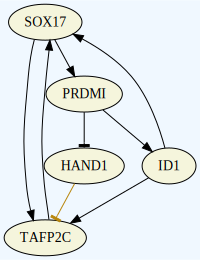

In [54]:
k = 0
spec_index = results[k][0]
net_spec = network_specs[spec_index]
net_spec_str = NetworkSpecStr(net_spec)
network = DSGRN.Network(net_spec_str)

DSGRN.DrawGraph(network)

# Conjugate method ( All LU equilibrim)

In [7]:
from stableStatistics import *
import numpy as np
from itertools import permutations,product

In [3]:
# for a single equilibrium
nw = 'nw.txt'
istates = {'SOX17':'L', 'PRDMI':'L', 'HAND1':'L', 'ID1':'L','TAFP2C':'L'}
conj = computetotalprop(nw,istates)*100

print('Conjugate method: {}'.format(conj))

Conjugate method: 4.083333333333332


In [4]:
# for a single equilibrium
nw = 'nw.txt'

In [9]:
def getAllThresholdOrders(outedges):
    # alphabetical order for node
    keys = sorted(outedges.keys())
    
    temp = []
    for node in keys:
        temp.append(permutations(outedges[node]))
    
    ret = product(*temp)
    return ret

def getAllCells(outedgeOrder):
    nodelist = sorted(outedgeOrder.keys())
    temp = []
    for node in nodelist:
        curr = []
        thresholds = outedgeOrder[node]
        for i in range(len(thresholds)-1):
            curr.append([thresholds[i],thresholds[i+1]])
        curr = [[-float('Inf'), thresholds[0]]] + curr + [[thresholds[-1],float('Inf')]]
        
        temp.append(curr)
    
    #print(temp)
    ret = product(*temp)
    return ret

def getPartOfOrder(cell,outedgeOrder,polyindexDict):
    ret = dict()
    for node in outedgeOrder:
        thresholds = sorted(outedgeOrder[node])
        low,high = cell[node]
        polyindex= int(''.join([str(x) for x in polyindexDict[node]]),2)
        # part of the order
        partorder = []
        if low in thresholds:
            # add the threshold index
            partorder.append(-thresholds.index(low)-1)
        partorder.append(polyindex)
        
        if high in thresholds:
            partorder.append(-thresholds.index(high)-1)
        
        ret[node] = partorder
            
    return ret

In [15]:
def getSingleCellEquilibriumRestrictions(nw,singleCell):
    
    information = parser(nw)
    
    
    
    # get the ouput edges
    inedges = information[1]
    nodelist = sorted(inedges.keys())

    # sort inedges 
    for node in inedges:
        inedges[node] = sorted(inedges[node])

    outedges = dict()
    for node in inedges:
        for inedge in inedges[node]:
            if inedge not in outedges:
                outedges[inedge] = []
            outedges[inedge].append(node)
            
    for node in outedges:
        outedges[node] = sorted(outedges[node])
        
    # activation and repression information
    arinedges = information[3]

    edgeARInformation = dict()

    for node in inedges:
        for i in range(len(inedges[node])):
            inode = inedges[node][i]
            arinfo = arinedges[node][i]
            edgeARInformation[(inode,node)] = arinfo


    # one possible outedge order 
    allTOrders = getAllThresholdOrders(outedges)
    count = 1


    ret = []
    # start the iteration
    for orders in allTOrders:
        outedgeOrder = dict()
        for i in range(len(nodelist)):
            outedgeOrder[nodelist[i]] = orders[i]

        #cells = dict()

        #print(outedgeOrder)

        #if count > 0:
        #    break

        #for node in outedgeOrder:
        #    cells[node] = [-float('Inf')] + outedgeOrder[node] + [float('Inf')]


        # one possible cell
        cells = [singleCell]

        for rawcell in cells:
            cell = dict()
            keys = sorted(outedgeOrder.keys())
            for i in range(len(keys)):
                cell[keys[i]] = rawcell[i]

            # generate polynomial index for each 
            # the order of input edge is left to right by smaller to bigger of alphabetical order
            polyindexDict = dict()
            for node in inedges:
                polyindex = []
                inedge = inedges[node]
                for inode in inedge:
                    thresholdOrder = outedgeOrder[inode]
                    index = thresholdOrder.index(node)

                    # get the index of cell
                    low, high = cell[inode]
                    if low == -float('Inf'):
                        low = -float('Inf')
                    else:
                        low  =thresholdOrder.index(low)

                    if high == float('Inf'):
                        high = float('Inf')
                    else:
                        high  =thresholdOrder.index(high)

                    lowhigh = -1
                    if index<= low:
                        lowhigh = 1
                    else:
                        lowhigh = 0

                    ar = edgeARInformation[(inode,node)]
                    if (lowhigh==0 and ar == 'A') or (lowhigh==1 and ar == 'R'):
                        polyindex.append(0)
                    else:
                        polyindex.append(1)

                polyindexDict[node] = polyindex


            porder = getPartOfOrder(cell,outedgeOrder,polyindexDict)        
            ret.append(porder)
            
    return ret

In [2]:
def getAllEquilibriumRestrictions(nw):
    
    information = parser(nw)
    
    
    
    # get the ouput edges
    inedges = information[1]
    nodelist = sorted(inedges.keys())

    # sort inedges 
    for node in inedges:
        inedges[node] = sorted(inedges[node])

    outedges = dict()
    for node in inedges:
        for inedge in inedges[node]:
            if inedge not in outedges:
                outedges[inedge] = []
            outedges[inedge].append(node)
            
    for node in outedges:
        outedges[node] = sorted(outedges[node])
        
    # activation and repression information
    arinedges = information[3]

    edgeARInformation = dict()

    for node in inedges:
        for i in range(len(inedges[node])):
            inode = inedges[node][i]
            arinfo = arinedges[node][i]
            edgeARInformation[(inode,node)] = arinfo


    # one possible outedge order 
    allTOrders = getAllThresholdOrders(outedges)
    count = 1


    ret = []
    # start the iteration
    for orders in allTOrders:
        outedgeOrder = dict()
        for i in range(len(nodelist)):
            outedgeOrder[nodelist[i]] = orders[i]

        cells = dict()

        #print(outedgeOrder)

        #if count > 0:
        #    break

        #for node in outedgeOrder:
        #    cells[node] = [-float('Inf')] + outedgeOrder[node] + [float('Inf')]


        # one possible cell
        cells = getAllCells(outedgeOrder)

        for rawcell in cells:
            cell = dict()
            keys = sorted(outedgeOrder.keys())
            for i in range(len(keys)):
                cell[keys[i]] = rawcell[i]

            # generate polynomial index for each 
            # the order of input edge is left to right by smaller to bigger of alphabetical order
            polyindexDict = dict()
            for node in inedges:
                polyindex = []
                inedge = inedges[node]
                for inode in inedge:
                    thresholdOrder = outedgeOrder[inode]
                    index = thresholdOrder.index(node)

                    # get the index of cell
                    low, high = cell[inode]
                    if low == -float('Inf'):
                        low = -float('Inf')
                    else:
                        low  =thresholdOrder.index(low)

                    if high == float('Inf'):
                        high = float('Inf')
                    else:
                        high  =thresholdOrder.index(high)

                    lowhigh = -1
                    if index<= low:
                        lowhigh = 1
                    else:
                        lowhigh = 0

                    ar = edgeARInformation[(inode,node)]
                    if (lowhigh==0 and ar == 'A') or (lowhigh==1 and ar == 'R'):
                        polyindex.append(0)
                    else:
                        polyindex.append(1)

                polyindexDict[node] = polyindex


            porder = getPartOfOrder(cell,outedgeOrder,polyindexDict)        
            ret.append(porder)
            
    return ret

In [10]:
ret = getAllEquilibriumRestrictions(nw)

In [11]:
ret[0]

{'HAND1': [1, -1],
 'ID1': [0, -1],
 'PRDMI': [0, -1],
 'SOX17': [1, -1],
 'TAFP2C': [-1, 1]}

In [14]:
ret[1]

{'HAND1': [1, -1],
 'ID1': [0, -1],
 'PRDMI': [0, -1],
 'SOX17': [1, -1],
 'TAFP2C': [-1, 1]}

In [13]:
ret[2]

{'HAND1': [1, -1],
 'ID1': [0, -1],
 'PRDMI': [1, -1],
 'SOX17': [-1, 0, -2],
 'TAFP2C': [1, -1]}